# 09: Geopandas exercise solutions

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point, Polygon
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
datapath = Path('../data/geopandas/')

## TEST YOUR SKILLS #0
- make a new geodataframe of the parks
- add a columns with centroids for each park
- plot an interactive window with the park centroids and the neighborhoods
- hints: 
    - remember the shapely methods are available for each geometry object (e.g. `centroid()`) 
    - you can loop over the column in a couple different ways
    - you can define which columns contains the geometry of a geodataframe
    - you will likely have to define the CRS

In [3]:
parks = gp.read_file(datapath / 'Madison_Parks.geojson')
hoods = gp.read_file(datapath / 'Neighborhood_Associations.geojson')

In [4]:
# loopy solution
parks_cent = parks.copy()
centroids = []
for i in parks_cent.geometry.values:
    centroids.append(i.centroid)
parks_cent['centroid'] = centroids

In [5]:
# do it all at once with a list comprehension
parks_cent['centroid'] = [i.centroid for i in parks_cent.geometry]

In [6]:
# set the geometry and CRS
parks_cent.set_geometry('centroid', inplace=True)
parks_cent.set_crs(parks.crs, inplace=True);

In [7]:
m_hoods = hoods.explore()
parks_cent.explore(m=m_hoods)

## TEST YOUR SKILLS #1
Using the `bounds` geodataframe you just made, write a function to visualize predicate behaviors.
- your function should accept a left geodataframe, a right geodataframe, and a string for the predicate
- your function should plot:
    - the left geodataframe in (default) blue
    - the result of the spatial join operation in another color
    - the right geodataframe in another color with outline only
- then you should set the title of the plot to the string predicate value used
- the geodataframes to test with are `isthmus_parks` and `bounds`
- your function should `return` the joined geodataframe

- a couple hints:
    - in the `plot` method are a couple args called `facecolor` and `edgecolor` that will help plot the rectangle
    - there are other predicates to try out 

- _advanced options_: if that was easy, you can try a couple other things like:
    - explore joins with points and lines in addition to just polygons
    - change around the `bounds` polygon dimensions 
    - use `explore()` to make an interactive map

### first have to bring over some things from the main lesson

In [8]:
parks.to_crs(3071, inplace=True)
hoods.to_crs(parks.crs, inplace=True)
isthmus = hoods.loc[hoods['NEIGHB_NAME'].str.contains('Marquette') | 
                   hoods['NEIGHB_NAME'].str.contains('Tenney')]
from shapely.geometry import box
bbox = box(570600, 290000, 573100, 291700)
bounds = gp.GeoDataFrame(geometry=[bbox],crs=parks.crs)
isthmus_parks = gp.sjoin(left_df=parks, right_df=isthmus)
isthmus_parks.drop(columns=[ 'index_right','OBJECTID_right', 'NA_ID', 'STATUS', 'CLASSIFICA', 'Web',
       'ShapeSTArea', 'ShapeSTLength'], inplace=True)

In [9]:
def show_predicate(ldf,rdf,predicate):
    sj = gp.sjoin(ldf, rdf, predicate=predicate)
    ax = ldf.plot()
    sj.plot(ax=ax, color='black')
    rdf.plot(facecolor='none', edgecolor='orange', ax=ax)
    ax.set_title(predicate)
    return sj

,OBJECTID_left,Park_ID,Type,Acreage,Park_Name,ShortName,Subtype,SHAPESTArea,SHAPESTLength,geometry,NEIGHB_NAME,index_right
6,6422,1360,NEIGHBORHOOD,6.08,Yahara Place Park,Yahara Place,None,264814.254303,4619.706039,"POLYGON ((572969.327 290871.975, 572979.154 29...",Marquette Neighborhood Association,0
12,6428,3540,TRAFFICWAY,0.10,Few Street (South) Street End,Few St,None,4522.502594,270.158029,"POLYGON ((572000.229 289978.256, 572017.381 28...",Marquette Neighborhood Association,0
19,6435,3480,TRAFFICWAY,0.12,Baldwin Street End,Baldwin St,None,5319.010742,294.682954,"POLYGON ((572164.248 290098.321, 572179.960 29...",Marquette Neighborhood Association,0
49,6465,1240,MINI,0.66,Morrison Park,Morrison,None,28667.633148,680.142299,"POLYGON ((572460.118 290317.086, 572465.604 29...",Marquette Neighborhood Association,0
56,6472,1100,OPEN SPACE,7.66,Yahara River Parkway,Yahara River,None,333593.558197,13219.124814,"MULTIPOLYGON (((572463.071 290603.880, 572425....",Marquette Neighborhood Association,0


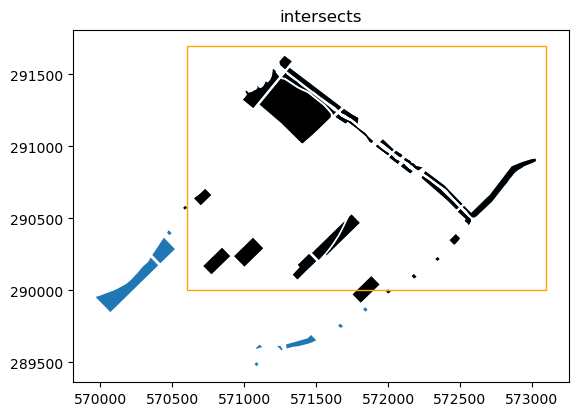

In [10]:
sj = show_predicate(isthmus_parks, bounds, 'intersects')
sj.head()

,geometry,index_right,OBJECTID_left,Park_ID,Type,Acreage,Park_Name,ShortName,Subtype,SHAPESTArea,SHAPESTLength,NEIGHB_NAME
0,"POLYGON ((573100.000 290000.000, 573100.000 29...",35,6451,3590,TRAFFICWAY,0.08,Paterson Street (North) Street End,Paterson St,None,3549.678101,239.046579,Tenney-Lapham Neighborhood Association
0,"POLYGON ((573100.000 290000.000, 573100.000 29...",12,6428,3540,TRAFFICWAY,0.10,Few Street (South) Street End,Few St,None,4522.502594,270.158029,Marquette Neighborhood Association
0,"POLYGON ((573100.000 290000.000, 573100.000 29...",92,6509,1000,MINI,3.58,Orton Park,Orton,None,156086.664276,1712.836076,Marquette Neighborhood Association


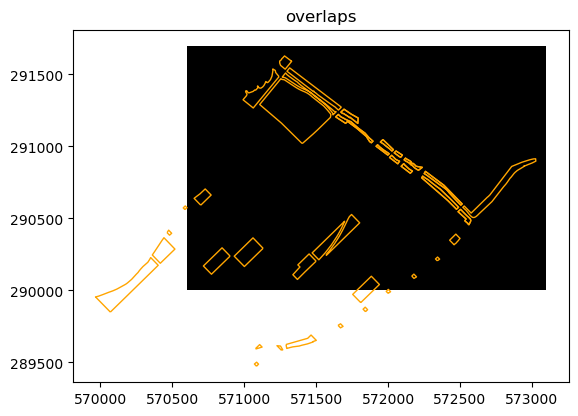

In [11]:
sj = show_predicate(bounds, isthmus_parks, 'overlaps')
sj.head()

## TEST YOUR SKILLS _OPTIONAL_
We have an Excel file that contains a crosswalk between SPECIES number as provided and species name. Can we bring that into our dataset and evaluate some conclusions about tree species by neighborhood?
- start with the `trees_with_hoods` GeoDataFrame
- load up and join the data from datapath / 'Madison_Tree_Species_Lookup.xlsx'
- hint: check the dtypes before merging - if you are going to join on a column, the column must be the same dtype in both dataframes
- Make a multipage PDF with a page for each neighborhood showing a bar chart of the top ten tree species (by name) in each neighborhood
- Make a map (use explore, or save to SHP or geojson) showing the neighborhoods with a color-coded field showing the most common tree species for each neighborhood

You will need a few pandas operations that we have only touched on a bit:  

`groupby`, `count`, `merge`, `read_excel`, `sort_values`, `iloc`

In [12]:
# read back in the trees and hoods data
trees = gp.read_file(datapath / 'Street_Trees.geojson', index_col=0)
trees.to_crs(hoods.crs, inplace=True)
trees_with_hoods = trees[['SPECIES','DIAMETER','geometry']].sjoin(hoods[['NEIGHB_NAME','geometry']])
trees_with_hoods.head()

,SPECIES,DIAMETER,geometry,index_right,NEIGHB_NAME
0,554,22.0,POINT (569406.122 285635.225),6,Bram's Addition Neighborhood Association
1,554,20.0,POINT (569391.615 285635.545),6,Bram's Addition Neighborhood Association
2,320,14.0,POINT (569383.333 285772.643),6,Bram's Addition Neighborhood Association
3,320,20.0,POINT (569407.725 285782.686),6,Bram's Addition Neighborhood Association
4,320,20.0,POINT (569431.459 285792.707),6,Bram's Addition Neighborhood Association


In [13]:
# now read the excel file with tree species lookup - might need to fiddle with skiprows parameter
tree_species = pd.read_excel(datapath / 'Madison_Tree_Species_Lookup.xlsx', 
                             skiprows = 6)
tree_species

,Code,Description
0,768,Cherry 'Pink Flair'
1,769,Amur Chokecherry
2,762,Black Cherry
3,666,Crabapple 'Adirondack'
4,665,Crabapple 'Sugar Tyme'
...,...,...
248,800,Oak Spp.
249,681,White Mulberry
250,680,Mulberry Spp.
251,805,Buckthorn Spp.


In [14]:
# check out the data types 
tree_species.dtypes

Code            int64
Description    object
dtype: object

In [15]:
trees_with_hoods.dtypes

SPECIES          object
DIAMETER        float64
geometry       geometry
index_right       int64
NEIGHB_NAME      object
dtype: object

In [16]:
# d'oh! Code in tree_species and SPECIES in trees_with_hoods are different types.
# To make them consistent, let's convert SPECIES in trees_with_hoods to int
trees_with_hoods.SPECIES = [int(i) for i in trees_with_hoods.SPECIES]

In [17]:
trees_with_hoods.dtypes

SPECIES           int64
DIAMETER        float64
geometry       geometry
index_right       int64
NEIGHB_NAME      object
dtype: object

In [18]:
# now we can merge - check out the left_on, right_on args
trees_final = trees_with_hoods.merge(tree_species, left_on='SPECIES', right_on='Code')
trees_final

,SPECIES,DIAMETER,geometry,index_right,NEIGHB_NAME,Code,Description
0,554,22.0,POINT (569406.122 285635.225),6,Bram's Addition Neighborhood Association,554,Honeylocust Var.
1,554,20.0,POINT (569391.615 285635.545),6,Bram's Addition Neighborhood Association,554,Honeylocust Var.
2,554,8.0,POINT (569453.239 285930.349),6,Bram's Addition Neighborhood Association,554,Honeylocust Var.
3,554,17.0,POINT (569463.866 285930.348),6,Bram's Addition Neighborhood Association,554,Honeylocust Var.
4,554,20.0,POINT (569478.882 285930.117),6,Bram's Addition Neighborhood Association,554,Honeylocust Var.
...,...,...,...,...,...,...,...
109750,976,19.0,POINT (568756.395 285356.696),11,Burr Oaks Neighborhood Association,976,Elm 'Regal'
109751,976,15.0,POINT (568814.361 285356.511),11,Burr Oaks Neighborhood Association,976,Elm 'Regal'
109752,976,10.0,POINT (568827.546 285356.119),11,Burr Oaks Neighborhood Association,976,Elm 'Regal'
109753,80,4.0,POINT (566329.451 283988.236),2,Arbor Hills Neighborhood Association,80,Dawn Redwood


In [19]:
# now the multipage plots
with PdfPages(datapath / 'TreePlots.pdf') as outpdf:
    # first groupby neighborhoods 
    for cn, cg in trees_final.groupby('NEIGHB_NAME'):
        #then, for each neighborhood, group by "Description" to get counts by name
        counts = cg.groupby('Description')['SPECIES'].count()
        # sort them in reverse value
        counts.sort_values(ascending=False, inplace=True)
        #make a bar chart of the top ten counts
        counts[:10].plot.bar()
        # set up a title
        plt.title(f'top 10 trees in {cn}')
        # when the x-axis labels are long they can get cut off. tight_layout can help
        plt.tight_layout()
        outpdf.savefig()
        plt.close('all')

In [20]:
# we can do this in an extra-pythonic way as well, chaining operations together
# advantage is it's faster to run but can be harder to initially understand and debug
with PdfPages(datapath / 'TreePlots.pdf') as outpdf:
    # first groupby neighborhoods 
    for cn, cg in trees_final.groupby('NEIGHB_NAME'):
        cg.groupby('Description')['SPECIES'].count().sort_values(ascending=False)[:10].plot.bar()
        # set up a title
        plt.title(f'top 10 trees in {cn}')
        # when the x-axis labels are long they can get cut off. tight_layout can help
        plt.tight_layout()
        outpdf.savefig()
        plt.close('all')

### Now let's find the most common tree species in each neighborhood and make a map. There are some ["sophisticated" ways](https://stackoverflow.com/questions/52243060/get-row-value-of-maximum-count-after-applying-group-by-in-pandas) using lots of pandas intrinsic functionality that can work, but we can also do it in a few (hopefully) logical explicit steps. 

In [21]:
# we can make a couple empty lists and just append the neighborhood name and the index of the 
# maximum occuring tree species in each in a loop. Still some "cleverness"
hood = []
max_tree = []
for cn, cg in trees_final.groupby('NEIGHB_NAME'):
    hood.append(cn)
    max_tree.append(cg.groupby('Description').count().sort_values(by='SPECIES', ascending=False).iloc[0].name)

In [22]:
# make a dataframe with these values
mts = pd.DataFrame(index=hood, data={'max_tree':max_tree})

In [23]:
#now join this back into the GeoDataFrame of hoods
hoods.merge(mts, left_on='NEIGHB_NAME', right_index=True)[['NEIGHB_NAME','max_tree', 'geometry']].explore(column='max_tree')